# Task 4 - Anomaly detection using autoencoders

### Deadline Tuesday, June 27, 2023 at 11:59 p.m

# IMPORTANT SUBMISSION INSTRUCTIONS

- When you're done, download the notebook and rename it to task4_[name].ipynb
- Only submit the `ipynb` file, no other file is required.
- The deadline is strict.
- Minimal requirement for passing: solving all code cells.

Implementation
- Do not change the cells which are marked as "Do not change", similarly write your solution to the marked cells.

# Topics

In this exercise sheet, you will:
- Work with a dataset for `dynamic behavior analysis of automotive software systems`.
- Implement autoencoders (AEs) for unsupervised anomaly detection.
- Compare MLP-based and CNN-based AEs.
- Vary architecture to improve model performance.
- Apply scheduled learning rate.
- Evaluate the performance of the model.

*We are looking forward to seeing your solutions! Have fun!*

# Related publications
 - Abboush, M.; Bamal, D.; Knieke, C.; Rausch, A. Hardware-in-the-Loop-Based Real-Time Fault Injection Framework for Dynamic Behavior Analysis of Automotive Software Systems. Sensors 2022, 22, 1360. https://doi.org/10.3390/s22041360

 - Abboush, M.; Bamal, D.; Knieke, C.; Rausch, A. Intelligent Fault Detection and Classification Based on Hybrid Deep Learning Methods for Hardware-in-the-Loop Test of Automotive Software Systems. Sensors 2022, 22, 4066. https://doi.org/10.3390/s22114066

## Tutorials

Some python libraries are required to accomplish the tasks assigned in this homework. If you feel like you need to follow a tutorial before, feel free to do so:
*   [Scikit-learn Tutorials](https://www.tensorflow.org/tutorials)
*   [TensorFlow Tutorials](https://scikit-learn.org/stable/tutorial/index.html)
*   [Matplotlib Tutorials](https://matplotlib.org/stable/tutorials/index.html)

## Imports

In [2]:
import numpy as np
import pandas as pd
import glob

import tensorflow as tf
from tensorflow.keras import models, layers, optimizers, losses, callbacks
from sklearn.preprocessing import MinMaxScaler

import matplotlib.pyplot as plt
import seaborn as sns

SEED = 24
np.random.seed(SEED)

## System checks


In [3]:
gpus = tf.config.list_physical_devices('GPU')
cpus = tf.config.list_physical_devices('CPU')
print(gpus)
print(cpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


Choose your device for computation. CPU or one of your CUDA devices.

In [4]:
tf.config.set_visible_devices(gpus, 'GPU')

# Anomaly detection via autoencoders

Anomaly detection is a technique used to identify abnormal or anomalous patterns within a dataset. Autoencoders are neural networks that are trained to reconstruct their input data, typically by learning a compressed representation of the data in an intermediate layer called the **bottleneck layer**.

Anomalies can be identified using autoencoders by comparing the input data to the reconstructed output, as anomalies often result in a higher reconstruction error. In this task, we employ autoencoders for anomaly detection in automotive
software systems.


# Subtask 2.1

## Loading the dataset and pre-processing

The dataset consists of time-series sensor measurements of healthy and faulty operation of the system. The fault type in each file is as following:

| File name | Fault type|
|------|------|
| Faulty_0 | Stuck-at fault |
| Faulty_1 | Offset/bias fault |
| Faulty_2 | Noise fault |
| Faulty_3 | Packet loss fault |
| Faulty_4 | Stuck-at fault |
| Faulty_5 | Stuck-at & Noise faults |

In [76]:
data_dir = './Data/'
file_names_test = glob.glob(data_dir + 'Faulty*')
file_names_train = ['Healthy.csv']
file_names_test

['./Data/Faulty_5.csv',
 './Data/Faulty_0.csv',
 './Data/Faulty_1.csv',
 './Data/Faulty_4.csv',
 './Data/Faulty_3.csv',
 './Data/Faulty_2.csv']

In [77]:
data_train = []
for f in file_names_train:
    data_train.append(pd.read_csv(data_dir + f))

data_test = []
for f in file_names_test:
    data_test.append(pd.read_csv(f))

In [78]:
data_train[0]

,time,ENGINE_RPM,Trq_MeanEff_Engine_Mod[Nm],T_Water[degC],p_InMan[Pa],p_Rail[bar],v_vehicle[km|h],label
0,0.000999,-3.640000e-18,0.000000,84.532638,93626.12721,1.000000,8.695555e-322,0.0
1,0.010999,-3.640000e-18,0.000000,84.531967,93638.60039,1.000000,8.695555e-322,0.0
2,0.020999,-3.640000e-18,0.000000,84.531296,93651.06237,1.000000,8.695555e-322,0.0
3,0.030999,-3.640000e-18,0.000000,84.530625,93663.51317,1.000000,8.695555e-322,0.0
4,0.040999,-3.640000e-18,0.000000,84.529954,93675.95279,1.000000,8.695555e-322,0.0
...,...,...,...,...,...,...,...,...
21294,236.048119,2.907543e+03,43.061145,87.100135,34766.58279,120.016058,5.337122e+01,0.0
21295,236.058119,2.913160e+03,43.139859,87.100178,34782.23119,120.023348,5.338723e+01,0.0
21296,236.068119,2.908590e+03,43.112000,87.100221,34793.94748,120.030070,5.340333e+01,0.0
21297,236.078119,2.913704e+03,43.181202,87.100263,34806.25686,120.028256,5.341908e+01,0.0


#### TODO

- Visualize `ENGINE_RPM` of the healthy and one of the faulty time-series.

**Note:** Do not forget to add title, axis labels and a legend!
This applies in general, please keep in mind.

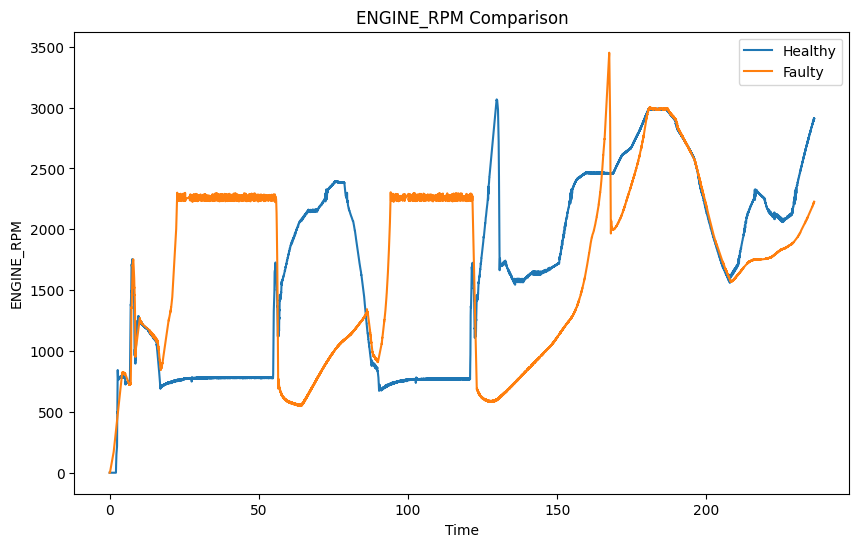

In [79]:
####################
## YOUR CODE HERE ##
####################

# Select the healthy data
healthy_data = data_train[0]

# Select one faulty data
faulty_data = data_test[1]

# Extract the 'time' and 'ENGINE_RPM' columns
healthy_time = healthy_data['time']
healthy_rpm = healthy_data['ENGINE_RPM']

faulty_time = faulty_data['time']
faulty_rpm = faulty_data['ENGINE_RPM']

# Plotting the ENGINE_RPM
plt.figure(figsize=(10, 6))
plt.plot(healthy_time, healthy_rpm, label='Healthy')
plt.plot(faulty_time, faulty_rpm, label='Faulty')
plt.title('ENGINE_RPM Comparison')
plt.xlabel('Time')
plt.ylabel('ENGINE_RPM')
plt.legend()
plt.show()


Let us extract the labels from the data and preserve them for later. Note that we will do an unsupervised anomaly detection. Therefore, we do not need labels for training.

In [80]:
y_train = []
for df in data_train:
    y_train.append(df['label'])

y_test = []
for df in data_test:
    y_test.append(df['label'])

In [81]:
y_train1=y_train
y_test1=y_test


We drop columns `time` and `label`, since they are not needed for training.

In [82]:
for df in data_train:
    df.drop(columns = ['label', 'time'], inplace = True)

for df in data_test:
    df.drop(columns = ['label', 'time'], inplace = True)

## Pre-processing

#### TODO
- Scale the data using `min-max scaler`.



In [83]:
####################
## YOUR CODE HERE ##
####################

scaler = MinMaxScaler()

# Scale the training data
for df in data_train:
    df[df.columns] = scaler.fit_transform(df[df.columns])

# Scale the test data
for df in data_test:
    df[df.columns] = scaler.transform(df[df.columns])


Since we are working with time-series data, it is beneficial to consider a sequence of time steps as the input of the model. In this way it is possible to exploit and learn the temporal dependencies in the data.

To this end, let us consider a sliding window with the length of $\ell$ and slide it over the whole time series with a stride of $s$ to generate our sequences. In this way, we will have:

$ X_0 = [x_0, ..., x_{\ell}]$

$ X_1 = [x_s, ..., x_{\ell+s}]$

$ X_2 = [x_{2s}, ..., x_{\ell+2s}]$

...

$ X_n = [x_{n\times s}, ..., x_{\ell+ n \times s}]$

as our input samples, where $x_t \in \mathbb{R}^p$ is the state of the system at time $t$.

In [84]:
def make_sequences(data, l, stride = 1):
    sequences = [data[i:i+l] for i in range(0, len(data) - l, stride)]
    return np.array(sequences)

#### TODO
 - Use the function above (`make_sequences`) to generate sequences. Use the sequence length of $\ell = 32$ and stride of 1 for healthy data (for training and validation) and stride of $\ell$ for faulty data (for testing).
 - Consider 80% of the healthy data for training and 20\% of it for validation.

**Note that we fit our model to the healthy data. After the training, we will employ the model to detect anomalies in the faulty time series.**

In [85]:
####################
## YOUR CODE HERE ##
####################
# Define sequence length and strides
sequence_length = 32
healthy_stride = 1
faulty_stride = sequence_length

# Generate sequences for healthy data (training and validation)
healthy_sequences = make_sequences(data_train[0].values, sequence_length, healthy_stride)



In [86]:
####################
## YOUR CODE HERE ##
####################

# Split healthy sequences into training and validation sets
healthy_train_size = int(0.8 * len(healthy_sequences))
healthy_train_sequences = healthy_sequences[:healthy_train_size]
healthy_val_sequences = healthy_sequences[healthy_train_size:]

# Generate sequences for faulty data (testing)
faulty_sequences = make_sequences(data_test[0].values, sequence_length, faulty_stride)


# Subtask 2.2

## MLP-based autoencoder

#### TODO
 - Consider the size of the bottleneck layer equal to 2.
 - Develop your model and print `model.summary()`.
 - Train the model.
 - Select the best model based on the validation loss.
 - Plot the learning curves.
 - Report the best validation loss you obtained.

In [25]:
####################
## YOUR CODE HERE ##
####################
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Define the model architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(sequence_length, 6)),
    Dense(32, activation='relu'),
    Dense(2, activation='relu'),  # Bottleneck layer
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(6, activation='sigmoid')  # Output layer
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Print the model summary
model.summary()

# Train the model
history = model.fit(healthy_train_sequences, healthy_train_sequences,
                    validation_data=(healthy_val_sequences, healthy_val_sequences),
                    epochs=100, batch_size=32, verbose=1)








Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_30 (Dense)            (None, 32, 64)            448       
                                                                 
 dense_31 (Dense)            (None, 32, 32)            2080      
                                                                 
 dense_32 (Dense)            (None, 32, 2)             66        
                                                                 
 dense_33 (Dense)            (None, 32, 32)            96        
                                                                 
 dense_34 (Dense)            (None, 32, 64)            2112      
                                                                 
 dense_35 (Dense)            (None, 32, 6)             390       
                                                                 
Total params: 5,192
Trainable params: 5,192
Non-traina

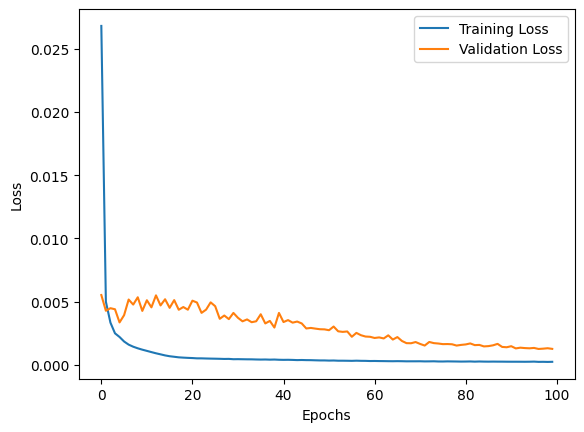

Best Validation Loss: 0.0012486126506701112


In [27]:
####################
## YOUR CODE HERE ##
####################
# Select the best model based on validation loss
best_model = model

# Plot the learning curves

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Report the best validation loss
best_val_loss = min(history.history['val_loss'])
print("Best Validation Loss:", best_val_loss)

# Subtask 2.3

## CNN-based autoencoder

#### TODO
- Consider the size of the bottleneck layer equal to 2.

 - Develop your model and print `model.summary()`. Use 1D convolution, 1D pooling, and dense layers in the encoder and dense, 1D convolution transpose and 1D up-sampling layers in the decoder.
 - Train the model.
 - Select the best model based on the validation loss.
 - Plot the learning curves.
 - Report the best validation loss you obtained.

In [30]:
####################
## YOUR CODE HERE ##
####################
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Dense
from keras.callbacks import ModelCheckpoint
# Define the input shape
input_shape = (32, 6)

# Encoder
inputs = Input(shape=input_shape)
x = Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(filters=8, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(filters=4, kernel_size=3, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Dense(units=2, activation='relu')(x)  # Bottleneck layer

# Decoder
x = Dense(units=4, activation='relu')(x)
x = UpSampling1D(size=2)(x)
x = Conv1D(filters=8, kernel_size=3, activation='relu', padding='same')(x)
x = UpSampling1D(size=2)(x)
x = Conv1D(filters=16, kernel_size=3, activation='relu', padding='same')(x)
x = UpSampling1D(size=2)(x)
outputs = Conv1D(filters=6, kernel_size=3, activation='sigmoid', padding='same')(x)

# Create the autoencoder model
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mean_squared_error')

# Print the model summary
model.summary()
# Define the ModelCheckpoint callback
checkpoint = ModelCheckpoint('best_model_weights_epoch_{epoch}.h5', save_best_only=True)

# Train the model
history = model.fit(healthy_train_sequences, healthy_train_sequences,
                    validation_data=(healthy_val_sequences, healthy_val_sequences),
                    epochs=100, batch_size=32, verbose=1,
                    callbacks=[checkpoint])




Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 6)]           0         
                                                                 
 conv1d_6 (Conv1D)           (None, 32, 16)            304       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 16, 16)           0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 16, 8)             392       
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 8, 8)             0         
 1D)                                                             
                                                                 
 conv1d_8 (Conv1D)           (None, 8, 4)              100 

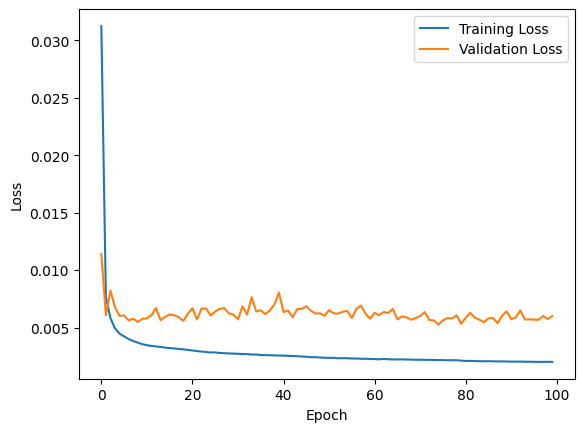

Best Validation Loss: 0.005268063396215439


In [32]:
####################
## YOUR CODE HERE ##
####################

best_epoch = np.argmin(history.history['val_loss'])
best_model = model

# Load the weights of the best model
best_model.load_weights('best_model_weights_epoch_9.h5')

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

best_val_loss = history.history['val_loss'][best_epoch]
print('Best Validation Loss:', best_val_loss)




# Subtask 2.4

## Visualize the data in the latent space

#### TODO
 - Take the encoder part of the model as a new model.
 - Use the encoder to map the test data to the latent space.
 - Plot the latent variables versus each other.

 **Note:** Do not forget to add title, axis labels and a legend!
This applies in general, please keep in mind.

In [36]:
# Extract the encoder part of the model
encoder = Model(inputs=model.input, outputs=model.get_layer('dense_38').output)
####################
## YOUR CODE HERE ##
####################
# Encode the test data

# Encode the test data
healthy_latent_space = encoder.predict(healthy_sequences)
faulty_latent_space = encoder.predict(faulty_sequences)



21/21 [==============================] - 0s 6ms/step


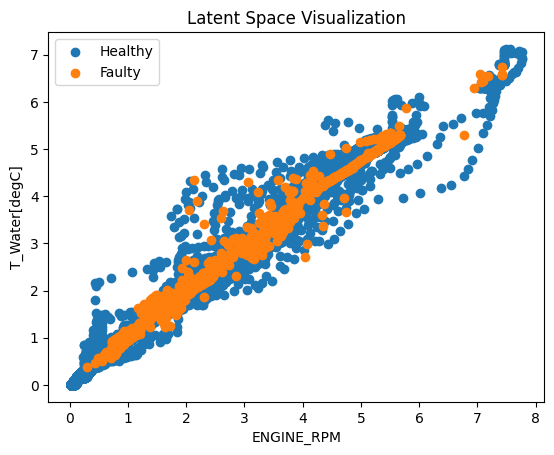

In [38]:
####################
## YOUR CODE HERE ##
####################

# Plot the latent variables
plt.scatter(healthy_latent_space[:, 0], healthy_latent_space[:, 1], label='Healthy')
plt.scatter(faulty_latent_space[:, 0], faulty_latent_space[:, 1], label='Faulty')
plt.title('Latent Space Visualization')
plt.xlabel('ENGINE_RPM')
plt.ylabel('T_Water[degC]')
plt.legend()
plt.show()

# Subtask 2.5

## Size of the latent vector (bottleneck layer)

#### TODO
 - Use the CNN-based autoencoder.
 - Change the size of the bottleneck layer to 2, 4, 8, 16.
 - Train the model.
 - Select the best model based on the validation loss.
  - Report the best validation loss you obtained for each model.
 - Plot the best validation loss for each model versus the size of the bottleneck layer.

 **Note:** Do not forget to add title, axis labels and a legend!
This applies in general, please keep in mind.


In [43]:
####################
## YOUR CODE HERE ##
####################
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D

def build_cnn_autoencoder(latent_size):
    # Encoder
    input_shape = (32, 6)
    input_layer = Input(shape=input_shape)
    encoded = Conv1D(16, 3, activation='relu', padding='same')(input_layer)
    encoded = MaxPooling1D(2, padding='same')(encoded)
    encoded = Conv1D(8, 3, activation='relu', padding='same')(encoded)
    encoded = MaxPooling1D(2, padding='same')(encoded)
    encoded = Conv1D(4, 3, activation='relu', padding='same')(encoded)
    encoded = MaxPooling1D(2, padding='same')(encoded)
    encoded = Conv1D(latent_size, 3, activation='relu', padding='same')(encoded)

    # Decoder
    decoded = Conv1D(4, 3, activation='relu', padding='same')(encoded)
    decoded = UpSampling1D(2)(decoded)
    decoded = Conv1D(8, 3, activation='relu', padding='same')(decoded)
    decoded = UpSampling1D(2)(decoded)
    decoded = Conv1D(16, 3, activation='relu', padding='same')(decoded)
    decoded = UpSampling1D(2)(decoded)
    decoded = Conv1D(6, 3, activation='sigmoid', padding='same')(decoded)

    # Autoencoder
    autoencoder = Model(inputs=input_layer, outputs=decoded)
    autoencoder.compile(optimizer='adam', loss='mean_squared_error')

    return autoencoder

latent_sizes = [2, 4, 8, 16]
validation_losses = []

for size in latent_sizes:
    # Build the model with the specified bottleneck layer size
    model = build_cnn_autoencoder(latent_size=size)

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    history = model.fit(healthy_train_sequences, healthy_train_sequences,
                        validation_data=(healthy_val_sequences, healthy_val_sequences),
                        epochs=100, batch_size=32, verbose=0)
    # Get the best validation loss and store it
    best_val_loss= min(history.history['val_loss'])
    validation_losses.append(best_val_loss)
    print(f"Size: {size}, Best Validation Loss: {best_val_loss}")

Size: 2, Best Validation Loss: 0.002896430203691125
Size: 4, Best Validation Loss: 0.0018483021995052695
Size: 8, Best Validation Loss: 0.003339278046041727
Size: 16, Best Validation Loss: 0.0007638539536856115


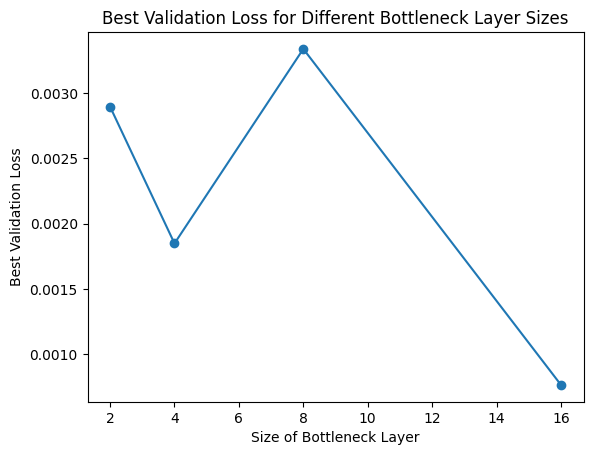

In [44]:
####################
## YOUR CODE HERE ##
####################

# Plot the best validation loss versus the size of the bottleneck layer
plt.plot(latent_sizes, validation_losses, marker='o')
plt.xlabel('Size of Bottleneck Layer')
plt.ylabel('Best Validation Loss')
plt.title('Best Validation Loss for Different Bottleneck Layer Sizes')
plt.show()


# Subtask 2.6

## Scheduled learning rate

When training a model, it is often useful to lower the learning rate as the training progresses. A learning rate schedule is a predefined mechanism that adjusts the learning rate between optimization steps during the training. [`tf.keras.optimizers.schedules`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules) provides several methods.


#### TODO
 - Consider the size of the bottleneck layer equal to 2.
 - Change the optimizer to use an exponential decay schedule: `tf.keras.optimizers.schedules.ExponentialDecay`.
 - Set the initial learning rate equal to 0.01.
 - Train the model and report the lowest validation loss.



In [46]:
####################
## YOUR CODE HERE ##
####################
from keras.optimizers import Adam
import tensorflow as tf

# Set the initial learning rate and decay rate
initial_learning_rate = 0.01
decay_rate = 0.1
decay_steps = 1000

# Define the learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=decay_steps,
    decay_rate=decay_rate,
)

# Create the optimizer with the learning rate schedule
optimizer = Adam(learning_rate=lr_schedule)

# Compile the model with the new optimizer
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [47]:
####################
## YOUR CODE HERE ##
####################
# Train the model
history = model.fit(
    healthy_train_sequences,
    healthy_train_sequences,
    validation_data=(healthy_val_sequences, healthy_val_sequences),
    epochs=100,
    batch_size=32,
    verbose=1
)

# Find the lowest validation loss
lowest_val_loss = min(history.history['val_loss'])
print("Lowest Validation Loss:", lowest_val_loss)

Epoch 1/100
532/532 [==============================] - 5s 7ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 2/100
532/532 [==============================] - 4s 7ms/step - loss: 6.6403e-04 - val_loss: 0.0012
Epoch 3/100
532/532 [==============================] - 3s 6ms/step - loss: 5.8418e-04 - val_loss: 0.0013
Epoch 4/100
532/532 [==============================] - 3s 6ms/step - loss: 5.5940e-04 - val_loss: 0.0012
Epoch 5/100
532/532 [==============================] - 3s 6ms/step - loss: 5.5107e-04 - val_loss: 0.0012
Epoch 6/100
532/532 [==============================] - 4s 7ms/step - loss: 5.4820e-04 - val_loss: 0.0012
Epoch 7/100
532/532 [==============================] - 3s 6ms/step - loss: 5.4714e-04 - val_loss: 0.0012
Epoch 8/100
532/532 [==============================] - 3s 6ms/step - loss: 5.4673e-04 - val_loss: 0.0012
Epoch 9/100
532/532 [==============================] - 3s 6ms/step - loss: 5.4661e-04 - val_loss: 0.0012
Epoch 10/100
532/532 [==============================] - 4s 

# Subtask 2.7

## Challenge

#### TODO
 - Use the CNN-based autoencoder.
 - Consider the size of the bottleneck layer equal to 8.
 - Modify the model architecture and the training process to obtain a better performance in reconstruction.
 - Select the best model based on the validation loss.
 - Plot the learning curves.
 - Report the best validation loss.

In [48]:
####################
## YOUR CODE HERE ##
####################

# Define the encoder architecture
input_seq = Input(shape=(32, 6))
encoded = Conv1D(32, 3, activation='relu', padding='same')(input_seq)
encoded = MaxPooling1D(2, padding='same')(encoded)
encoded = Conv1D(16, 3, activation='relu', padding='same')(encoded)
encoded = MaxPooling1D(2, padding='same')(encoded)
encoded = Conv1D(8, 3, activation='relu', padding='same')(encoded)
encoded = MaxPooling1D(2, padding='same')(encoded)
# Bottleneck layer
latent_space = Conv1D(8, 3, activation='relu', padding='same')(encoded)

# Define the decoder architecture
decoded = Conv1D(8, 3, activation='relu', padding='same')(latent_space)
decoded = UpSampling1D(2)(decoded)
decoded = Conv1D(16, 3, activation='relu', padding='same')(decoded)
decoded = UpSampling1D(2)(decoded)
decoded = Conv1D(32, 3, activation='relu', padding='same')(decoded)
decoded = UpSampling1D(2)(decoded)
decoded = Conv1D(6, 3, activation='sigmoid', padding='same')(decoded)

# Create the autoencoder model
autoencoder = Model(input_seq, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')




In [49]:
####################
## YOUR CODE HERE ##
####################

# Train the model
history = autoencoder.fit(
    healthy_train_sequences,
    healthy_train_sequences,
    validation_data=(healthy_val_sequences, healthy_val_sequences),
    epochs=100,
    batch_size=32,
    verbose=1
)

# Find the lowest validation loss
lowest_val_loss = min(history.history['val_loss'])
print("Lowest Validation Loss:", lowest_val_loss)


Epoch 1/100
532/532 [==============================] - 56s 8ms/step - loss: 0.0219 - val_loss: 0.0051
Epoch 2/100
532/532 [==============================] - 3s 6ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 3/100
532/532 [==============================] - 3s 6ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 4/100
532/532 [==============================] - 3s 6ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 5/100
532/532 [==============================] - 4s 7ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 6/100
532/532 [==============================] - 3s 6ms/step - loss: 0.0019 - val_loss: 0.0016
Epoch 7/100
532/532 [==============================] - 3s 6ms/step - loss: 0.0018 - val_loss: 0.0015
Epoch 8/100
532/532 [==============================] - 3s 6ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 9/100
532/532 [==============================] - 4s 7ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 10/100
532/532 [==============================] - 3s 6ms/step - loss: 0.0017 - val_l

# Subtask 2.8

## Reconstruction loss

#### TODO
 - Use the best model you have trained.
 - Compute the reconstruction loss for validation and test dataset.
    - You need to compute the loss for every time step.



In [98]:
####################
## YOUR CODE HERE ##
####################


# Load the weights of the best model
best_model.load_weights('best_model_weights_epoch_9.h5')

# Compile the model with the appropriate loss function
best_model.compile(optimizer='adam', loss='mean_squared_error')

# Predict the reconstructed sequences for the validation dataset
val_predictions = best_model.predict(healthy_val_sequences)

# Compute the reconstruction loss for each time step in the validation dataset
val_reconstruction_loss = np.mean(np.square(healthy_val_sequences - val_predictions), axis=1)

# Compute the average reconstruction loss across all time steps for the validation dataset
val_avg_reconstruction_loss = np.mean(val_reconstruction_loss)

# Predict the reconstructed sequences for the test dataset
test_predictions = best_model.predict(healthy_test_sequences)

# Compute the reconstruction loss for each time step in the test dataset
test_reconstruction_loss = np.mean(np.square(healthy_test_sequences - test_predictions), axis=1)

# Compute the average reconstruction loss across all time steps for the test dataset
test_avg_reconstruction_loss = np.mean(test_reconstruction_loss)

# Print the reconstruction loss for the validation and test datasets
print("Validation Reconstruction Loss:", val_avg_reconstruction_loss)
print("Test Reconstruction Loss:", test_avg_reconstruction_loss)



665/665 [==============================] - 3s 4ms/step
Validation Reconstruction Loss: 0.005484666545997902
Test Reconstruction Loss: 0.015927526417635337


In [ ]:
####################
## YOUR CODE HERE ##
####################

# Subtask 2.9

## Anomaly detection

#### TDOD
- Use the test dataset.
- Plot the ROC and precision-recall curves and report the area under the curve (AUC) for each of them.
- Select the threshold by allowing a false positive rate of 0.2.
- Detect anomalies using the threshold.

In [102]:
####################
## YOUR CODE HERE ##
####################

input_seq = Input(shape=(32, 6))
encoded = Conv1D(16, 3, activation='relu', padding='same')(input_seq)
encoded = MaxPooling1D(2, padding='same')(encoded)
encoded = Conv1D(8, 3, activation='relu', padding='same')(encoded)
encoded = MaxPooling1D(2, padding='same')(encoded)
encoded = Conv1D(4, 3, activation='relu', padding='same')(encoded)
encoded = MaxPooling1D(2, padding='same')(encoded)
latent_space = Dense(2)(encoded)
decoded = Dense(4)(latent_space)
decoded = UpSampling1D(2)(decoded)
decoded = Conv1D(8, 3, activation='relu', padding='same')(decoded)
decoded = UpSampling1D(2)(decoded)
decoded = Conv1D(16, 3, activation='relu', padding='same')(decoded)
decoded = UpSampling1D(2)(decoded)
decoded = Conv1D(6, 3, activation='sigmoid', padding='same')(decoded)

autoencoder = Model(input_seq, decoded)

autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

autoencoder.load_weights('best_model_weights_epoch_9.h5')

reconstruction_losses = autoencoder.evaluate(healthy_test_sequences, healthy_test_sequences, verbose=0)

# Identify the indices of the anomalous sequences in the test dataset
anomalous_indices = np.where(np.array(y_test) == 'anomalous')[0]

# Extract the anomalous sequences from the faulty_sequences variable
anomalous_test_sequences = faulty_sequences[anomalous_indices]


<ipython-input-102-0ccd47eee63a>:30: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  anomalous_indices = np.where(np.array(y_test) == 'anomalous')[0]


665/665 [==============================] - 2s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1029: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


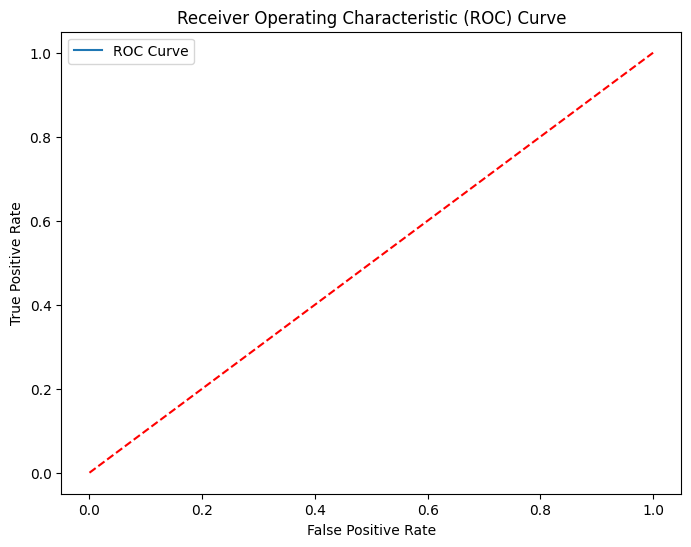

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


AUC-ROC: nan


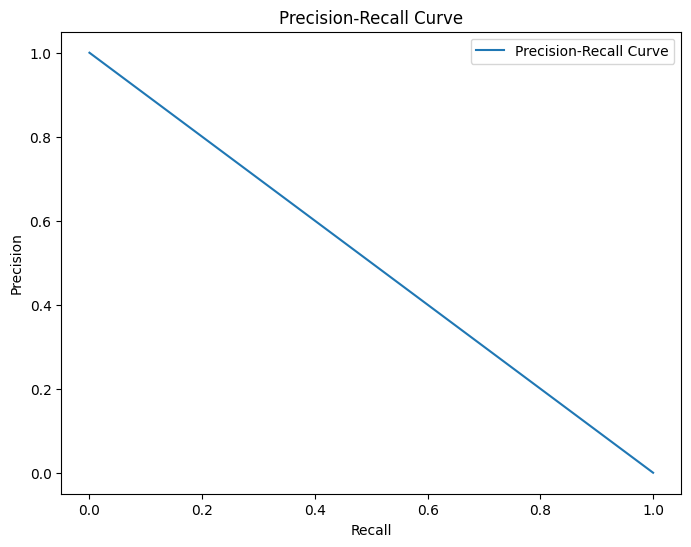

FPR at Desired Precision: 0.0
Threshold at Desired Precision: 0.0005864737945116458


In [103]:
# Load the weights of the best model
autoencoder.load_weights('best_model_weights_epoch_9.h5')

# Generate reconstructed sequences for the test dataset
reconstructed_sequences = autoencoder.predict(healthy_test_sequences)

# Compute the reconstruction error (Mean Squared Error) for each sequence
mse = np.mean(np.square(healthy_test_sequences - reconstructed_sequences), axis=(1, 2))

# Create the true labels vector
true_labels = np.concatenate([np.zeros(len(healthy_test_sequences)), np.ones(len(anomalous_test_sequences))])

# Calculate the False Positive Rate (FPR) and True Positive Rate (TPR) at different threshold values
fpr, tpr, thresholds = roc_curve(true_labels, mse)

# Plot the ROC curve and compute the Area Under the Curve (AUC)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

auc_roc = auc(fpr, tpr)
print('AUC-ROC:', auc_roc)

# Calculate the Precision, Recall, and Threshold values for different precision levels
precision, recall, thresholds = precision_recall_curve(true_labels, mse)

# Plot the Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

# Compute the FPR and Threshold for a desired precision level (e.g., 0.8)
desired_precision = 0.8
desired_precision_idx = np.argmax(precision[:-1] >= desired_precision)
desired_threshold = thresholds[desired_precision_idx]
fpr_at_desired_precision = fpr[desired_precision_idx]
print('FPR at Desired Precision:', fpr_at_desired_precision)
print('Threshold at Desired Precision:', desired_threshold)

# Detect anomalies using the threshold
predicted_labels = mse >= desired_threshold


# Subtask 2.10

## Evaluate model performance

#### TODO
 - Compute accuracy, recall, precision f1-score.
 - Explain the effect of selecting different values for the threshold on the performance of the model.

In [104]:
####################
## YOUR CODE HERE ##
####################
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

# Compute accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Compute recall
recall = recall_score(true_labels, predicted_labels)

# Compute precision
precision = precision_score(true_labels, predicted_labels)

# Compute F1-score
f1 = f1_score(true_labels, predicted_labels)

print('Accuracy:', accuracy)
print('Recall:', recall)
print('Precision:', precision)
print('F1-score:', f1)


Accuracy: 0.0
Recall: 0.0
Precision: 0.0
F1-score: 0.0


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
####################
## YOUR CODE HERE ##
####################

<span style='color:red'>**Your answer:**</span>

...

## Visualize the detected anomalies

#### TDOD
 - Plot `ENGINE_RPM` of one of the time series of the test dataset.
 - Visualize the healthy time steps by blue.
 - Visualize the true anomalous time steps by green.
 - Visualize the predicted anomalous time steps by red.

In [ ]:
####################
## YOUR CODE HERE ##
####################

